In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

%matplotlib inline

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda:0") 
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Classes & Setup**

In [92]:
class FoodDatasetTest(Dataset):
  
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
    image = Image.open(img_path)
    image.thumbnail((256,256))

    if(self.transform):
      image = self.transform(image)

    return image

In [93]:
test_dataset = FoodDatasetTest(csv_file='/content/drive/My Drive/Practice/FOODC/test.csv', 
                      root_dir='/content/drive/My Drive/Practice/FOODC/test_images/',
                      transform = transforms.Compose([
                        transforms.Resize(255),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
                      ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


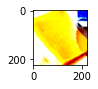

In [94]:
plt.figure(figsize=(1,1))
plt.imshow(test_dataset[3].permute(1,2,0))

## **Network & Prediction**



In [106]:
checkpoint = torch.load('/content/drive/My Drive/Practice/FOODC/checkpoints/20.pt')

In [107]:
# TORCHVISION RESNET
network = torchvision.models.resnet18().to(device)
network.fc = nn.Linear(network.fc.in_features, 61).cuda()

network.load_state_dict(checkpoint['model_state_dict'])
network.train = False

In [108]:
test_loader = DataLoader(test_dataset, 100)
test_preds = []

with torch.no_grad():
  for test_batch in test_loader:
    print("BATCH")
    images = test_batch
    images = images.cuda()
    preds = network(images)
    _, outputs =torch.max(preds.data,1)
    pr = preds.detach().cpu().numpy()
    for i in pr:
      test_preds.append(i)

BATCH
BATCH
BATCH
BATCH
BATCH


In [109]:
test_classes_cat = []
for pred in test_preds:
  test_classes_cat.append(pred.argmax())

In [117]:
print(test_classes_cat[0:5])
len(test_classes_cat)

[55, 56, 22, 13, 11]


484

## **Output CSV File**

In [111]:
classes_df = pd.read_csv('/content/drive/My Drive/Practice/FOODC/classes.csv',names=('ClassName','ClassName_cat'))
classes_df.head()

,ClassName,ClassName_cat
0,almonds,0
1,apple,1
2,avocado,2
3,banana,3
4,beer,4


In [112]:
classes_dict = classes_df[classes_df.columns[::-1]].to_dict()
classes_dict['ClassName'][0]

'almonds'

In [113]:
test_classes_names = []
for cat in test_classes_cat:
  test_classes_names.append(classes_dict['ClassName'][cat])

In [114]:
submissions_df = pd.DataFrame(test_classes_names,columns=['ClassName'])
submissions_df.head()

,ClassName
0,water
1,water-mineral
2,dark-chocolate
3,butter
4,bread-wholemeal


In [115]:
submissions_df.to_csv('/content/drive/My Drive/Practice/FOODC/submissions.csv',index=False)

In [116]:
from google.colab import files
files.download('/content/drive/My Drive/Practice/FOODC/submissions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>